<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()


#  Data Augmentation
def load_dataset(batch_size=64):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_data = datasets.SVHN(root="./data", split='train', download=True, transform=transform)
    val_data = datasets.SVHN(root="./data", split='test', download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_dataset()


100%|██████████| 182M/182M [00:26<00:00, 6.99MB/s]
100%|██████████| 64.3M/64.3M [00:14<00:00, 4.50MB/s]


In [3]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [4]:
# Training Function with Optimized Hyperparameters
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1, images.size(2))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc = 100 * correct / total
        history['loss'].append(total_loss / len(train_loader))
        history['accuracy'].append(train_acc)
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_labels, val_predictions, val_probs = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1, images.size(2))
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())
                val_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        precision = precision_score(val_labels, val_predictions, average='macro', zero_division=0)
        recall = recall_score(val_labels, val_predictions, average='macro', zero_division=0)
        f1 = f1_score(val_labels, val_predictions, average='macro', zero_division=0)
        auc = roc_auc_score(val_labels, val_probs, multi_class='ovo', average='macro')
        print(f"Epoch {epoch+1}/{epochs}: Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")
    return model, history


In [5]:
# Visualization Function
def plot_metrics(history, model_name):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Model Loss')
    plt.legend()
    plt.show()


Training RNN Model...
Epoch 1/20: Accuracy: 29.2678, Precision: 0.1797, Recall: 0.1849, F1-Score: 0.1392, AUC: 0.6627
Epoch 2/20: Accuracy: 49.9078, Precision: 0.4553, Recall: 0.4286, F1-Score: 0.4225, AUC: 0.8413
Epoch 3/20: Accuracy: 61.3015, Precision: 0.6287, Recall: 0.5595, F1-Score: 0.5661, AUC: 0.8987
Epoch 4/20: Accuracy: 70.5824, Precision: 0.6982, Recall: 0.6683, F1-Score: 0.6729, AUC: 0.9295
Epoch 5/20: Accuracy: 73.9820, Precision: 0.7160, Recall: 0.7167, F1-Score: 0.7154, AUC: 0.9475
Epoch 6/20: Accuracy: 77.3855, Precision: 0.7560, Recall: 0.7511, F1-Score: 0.7509, AUC: 0.9591
Epoch 7/20: Accuracy: 79.5982, Precision: 0.7871, Recall: 0.7709, F1-Score: 0.7776, AUC: 0.9640
Epoch 8/20: Accuracy: 78.1922, Precision: 0.7724, Recall: 0.7494, F1-Score: 0.7582, AUC: 0.9599
Epoch 9/20: Accuracy: 80.4740, Precision: 0.8003, Recall: 0.7840, F1-Score: 0.7891, AUC: 0.9680
Epoch 10/20: Accuracy: 80.1552, Precision: 0.7933, Recall: 0.7779, F1-Score: 0.7841, AUC: 0.9681
Epoch 11/20: Accu

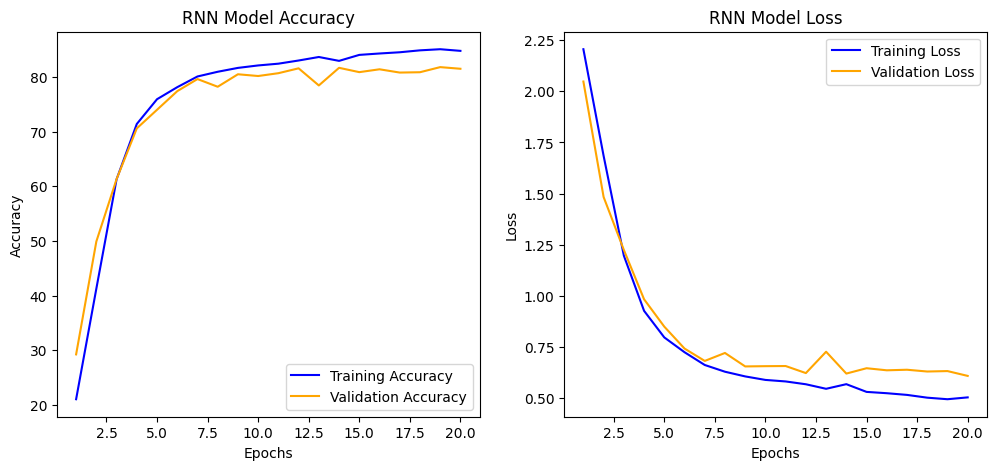

In [6]:
# Training Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size, hidden_size, output_size, num_layers = 32, 512, 10, 2
epochs, learning_rate = 20, 0.0005

criterion = nn.CrossEntropyLoss()

# Train RNN Model
print("Training RNN Model...")
rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=1e-5)
rnn_model, rnn_history = train_model(rnn_model, train_loader, val_loader, criterion, rnn_optimizer, device, epochs)

# Plot RNN Metrics
plot_metrics(rnn_history, "RNN")


Training LSTM Model...
Epoch 1/20: Accuracy: 77.6621, Precision: 0.7646, Recall: 0.7505, F1-Score: 0.7538, AUC: 0.9609
Epoch 2/20: Accuracy: 83.7738, Precision: 0.8294, Recall: 0.8208, F1-Score: 0.8227, AUC: 0.9795
Epoch 3/20: Accuracy: 87.1620, Precision: 0.8622, Recall: 0.8598, F1-Score: 0.8601, AUC: 0.9861
Epoch 4/20: Accuracy: 88.1646, Precision: 0.8703, Recall: 0.8681, F1-Score: 0.8689, AUC: 0.9874
Epoch 5/20: Accuracy: 88.6179, Precision: 0.8788, Recall: 0.8764, F1-Score: 0.8769, AUC: 0.9891
Epoch 6/20: Accuracy: 89.4476, Precision: 0.8893, Recall: 0.8838, F1-Score: 0.8859, AUC: 0.9903
Epoch 7/20: Accuracy: 89.2018, Precision: 0.8850, Recall: 0.8828, F1-Score: 0.8834, AUC: 0.9898
Epoch 8/20: Accuracy: 90.1314, Precision: 0.8952, Recall: 0.8946, F1-Score: 0.8948, AUC: 0.9910
Epoch 9/20: Accuracy: 90.8113, Precision: 0.9014, Recall: 0.9019, F1-Score: 0.9015, AUC: 0.9919
Epoch 10/20: Accuracy: 90.6192, Precision: 0.8986, Recall: 0.8974, F1-Score: 0.8976, AUC: 0.9914
Epoch 11/20: Acc

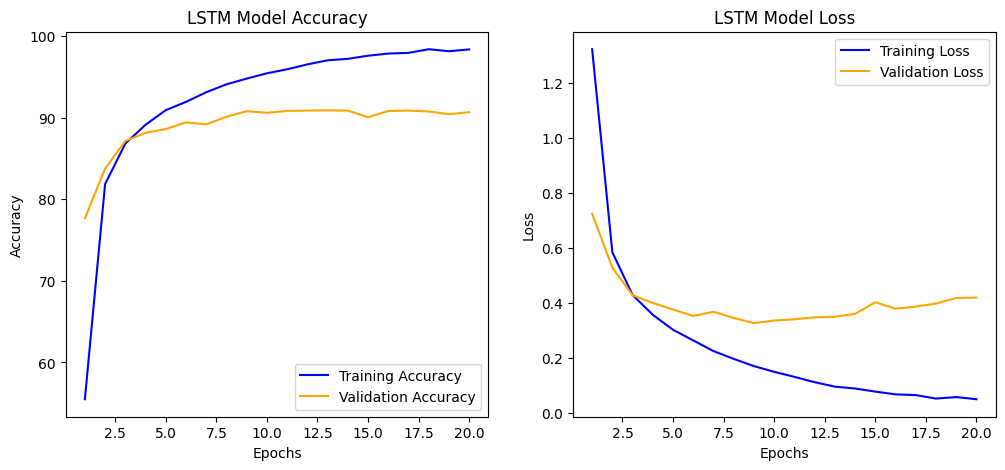

In [7]:
# Train LSTM Model
print("Training LSTM Model...")
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate)
lstm_model, lstm_history = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, epochs)

# Plot LSTM Metrics
plot_metrics(lstm_history, "LSTM")

Training GRU Model...
Epoch 1/20: Accuracy: 81.9876, Precision: 0.8064, Recall: 0.7999, F1-Score: 0.8025, AUC: 0.9737
Epoch 2/20: Accuracy: 87.0890, Precision: 0.8618, Recall: 0.8610, F1-Score: 0.8605, AUC: 0.9864
Epoch 3/20: Accuracy: 88.3874, Precision: 0.8748, Recall: 0.8733, F1-Score: 0.8724, AUC: 0.9891
Epoch 4/20: Accuracy: 90.0392, Precision: 0.8938, Recall: 0.8943, F1-Score: 0.8936, AUC: 0.9916
Epoch 5/20: Accuracy: 90.1621, Precision: 0.8932, Recall: 0.8919, F1-Score: 0.8917, AUC: 0.9909
Epoch 6/20: Accuracy: 91.0764, Precision: 0.9048, Recall: 0.9015, F1-Score: 0.9029, AUC: 0.9923
Epoch 7/20: Accuracy: 90.7498, Precision: 0.8997, Recall: 0.8989, F1-Score: 0.8988, AUC: 0.9919
Epoch 8/20: Accuracy: 90.4156, Precision: 0.8992, Recall: 0.8953, F1-Score: 0.8967, AUC: 0.9913
Epoch 9/20: Accuracy: 90.2351, Precision: 0.8932, Recall: 0.8952, F1-Score: 0.8937, AUC: 0.9916
Epoch 10/20: Accuracy: 90.1890, Precision: 0.8940, Recall: 0.8935, F1-Score: 0.8930, AUC: 0.9906
Epoch 11/20: Accu

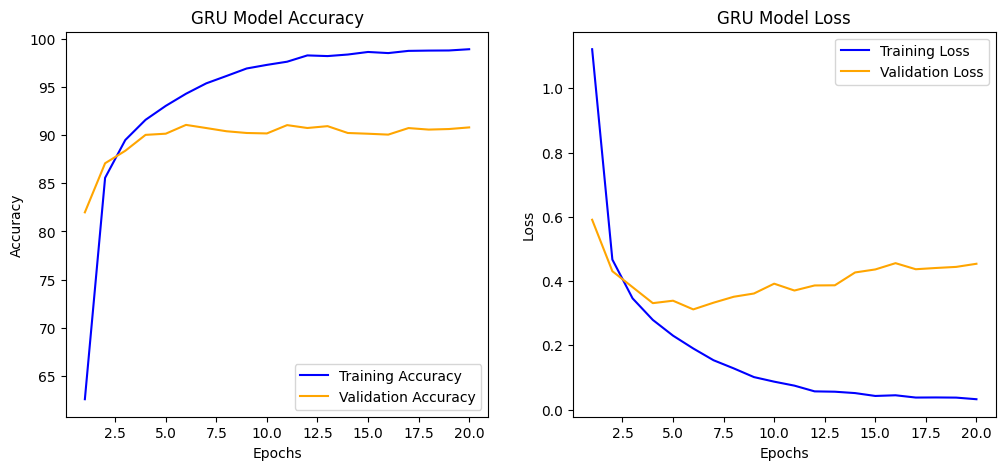

In [8]:
# Train GRU Model
print("Training GRU Model...")
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
gru_optimizer = optim.AdamW(gru_model.parameters(), lr=learning_rate)
gru_model, gru_history = train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer, device, epochs)

# Plot GRU Metrics
plot_metrics(gru_history, "GRU")

# Tensorflow

In [9]:
!pip install tensorflow

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [11]:
# Set random seed for reproducibility
def set_seed(seed=42):
    tf.random.set_seed(seed)

set_seed()

def load_tf_dataset(batch_size=64):
    dataset, info = tfds.load("svhn_cropped", split=['train', 'test'], as_supervised=True, with_info=True)
    train_data, test_data = dataset

    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = (image - 0.5) / 0.5
        image = tf.reshape(image, (32, 32))  # Reshape to (timesteps=32, features=32)
        return image, label


    train_data = train_data.map(preprocess).batch(batch_size).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)
    test_data = test_data.map(preprocess).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_data, test_data

train_data, test_data = load_tf_dataset()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.HBRPOI_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.HBRPOI_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.HBRPOI_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [12]:
# Define RNN Model (TensorFlow)
class RNNModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.rnn(x)
        return self.fc(x)

# Define LSTM Model (TensorFlow)
class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.lstm(x)
        return self.fc(x)

# Define GRU Model (TensorFlow)
class GRUModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = tf.keras.layers.GRU(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.gru(x)
        return self.fc(x)



In [13]:
# Define Training and Evaluation Function for TensorFlow Models
def train_tf_model(model, dataset, epochs=10):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(dataset, epochs=epochs, verbose=1)
    return history

def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        y_prob.extend(preds)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes=10), y_prob, multi_class='ovr')

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")

    return precision, recall, f1, auc


In [ ]:
# Training and Evaluating Models
hidden_size = 128
output_size = 10
epochs = 10

rnn_model = RNNModel(hidden_size, output_size)
lstm_model = LSTMModel(hidden_size, output_size)
gru_model = GRUModel(hidden_size, output_size)

print("Training RNN Model...")
rnn_history = train_tf_model(rnn_model, train_data, epochs)
print("Evaluating RNN Model...")
evaluate_model(rnn_model, test_data)

print("Training LSTM Model...")
lstm_history = train_tf_model(lstm_model, train_data, epochs)
print("Evaluating LSTM Model...")
evaluate_model(lstm_model, test_data)

print("Training GRU Model...")
gru_history = train_tf_model(gru_model, train_data, epochs)
print("Evaluating GRU Model...")
evaluate_model(gru_model, test_data)

Training RNN Model...
Epoch 1/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.3140 - loss: 1.9656
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5827 - loss: 1.2748
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6541 - loss: 1.0890
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6885 - loss: 0.9875
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7072 - loss: 0.9342
Epoch 6/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7227 - loss: 0.8904
Epoch 7/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7292 - loss: 0.8714
Epoch 8/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7416 - loss: 0.8350
Epoch 9/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7516 - loss: 0.8118
Epoch 10/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7568 - loss: 0.7916
Evaluating RNN Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━

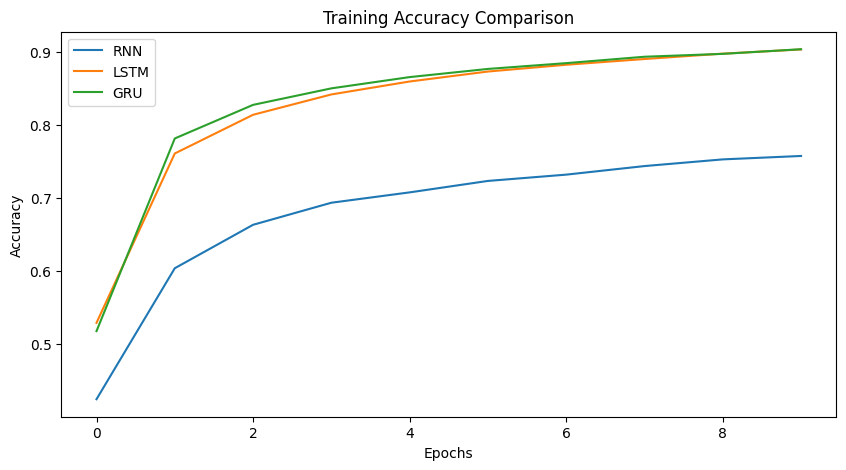

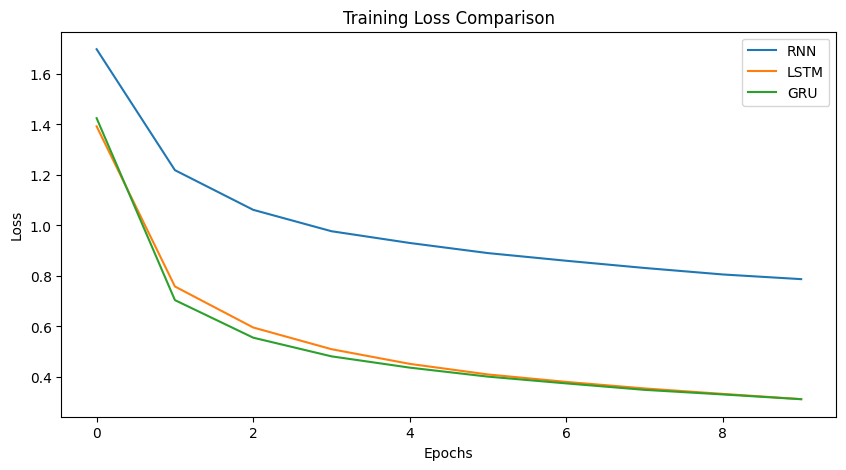

In [17]:
# Plot Training Accuracy
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'], label='RNN')
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(gru_history.history['accuracy'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'], label='RNN')
plt.plot(lstm_history.history['loss'], label='LSTM')
plt.plot(gru_history.history['loss'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


In [18]:
!jupyter nbconvert --clear-output --inplace RNN_LSTM_GRU.ipynb

[NbConvertApp] WARNING | pattern 'RNN_LSTM_GRU.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  